<a href="https://colab.research.google.com/github/AntonioMastroianni/Text_Mining/blob/main/Text_mining_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gzip
nltk.download('punkt')
nltk.download('stopwords')
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam



#download(stopwords)

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Data Loading


In [ ]:
sms = pd.read_csv("/content/gdrive/MyDrive/Text Mining/spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


EDA

In [ ]:
sms

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
label_counts = sms['label'].value_counts()
label_percentages = sms['label'].value_counts(normalize=True) * 100
print(label_counts, label_percentages)

ham     4825
spam     747
Name: label, dtype: int64 ham     86.593683
spam    13.406317
Name: label, dtype: float64


Words and character count

In [ ]:
sms['char_len'] = sms.message.apply(len)
sms['word_len'] = sms['message'].apply(lambda x: len(x.split(' ')))

In [ ]:
sms.head()

,label,message,char_len,word_len
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


(0.0, 500.0)

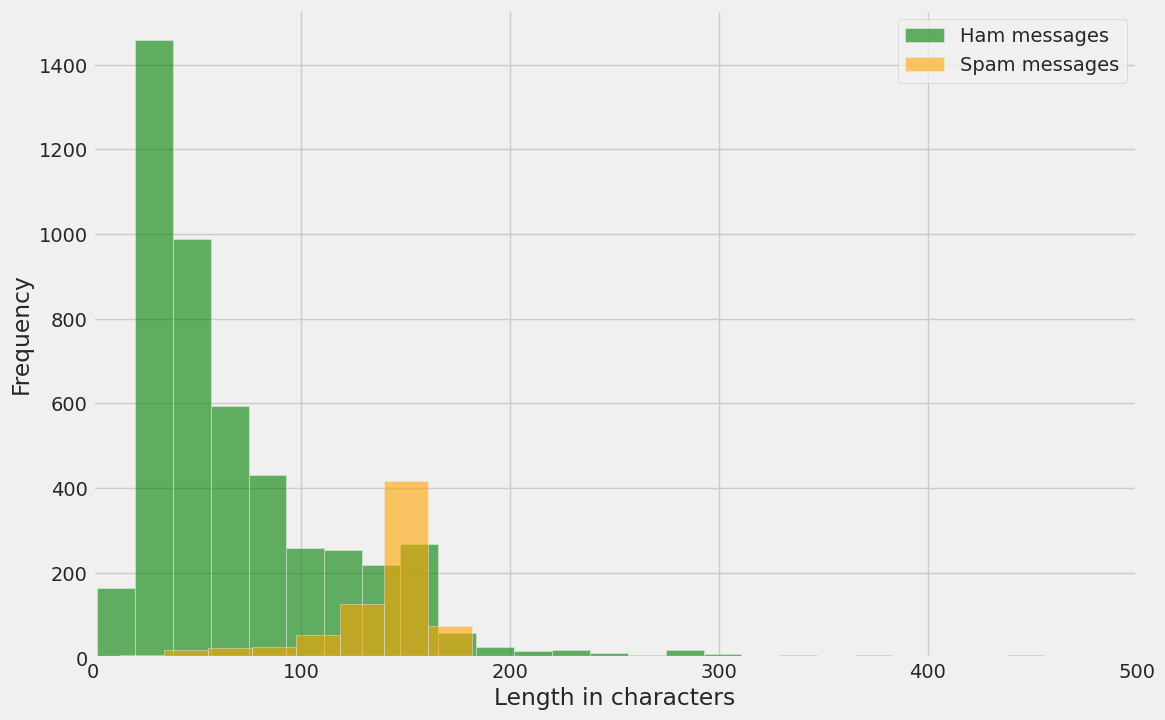

In [ ]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].char_len.plot(bins=50, kind='hist', color='green',
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].char_len.plot(kind='hist', color='orange',
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Length in characters")
plt.xlim(0, 500)

(0.0, 100.0)

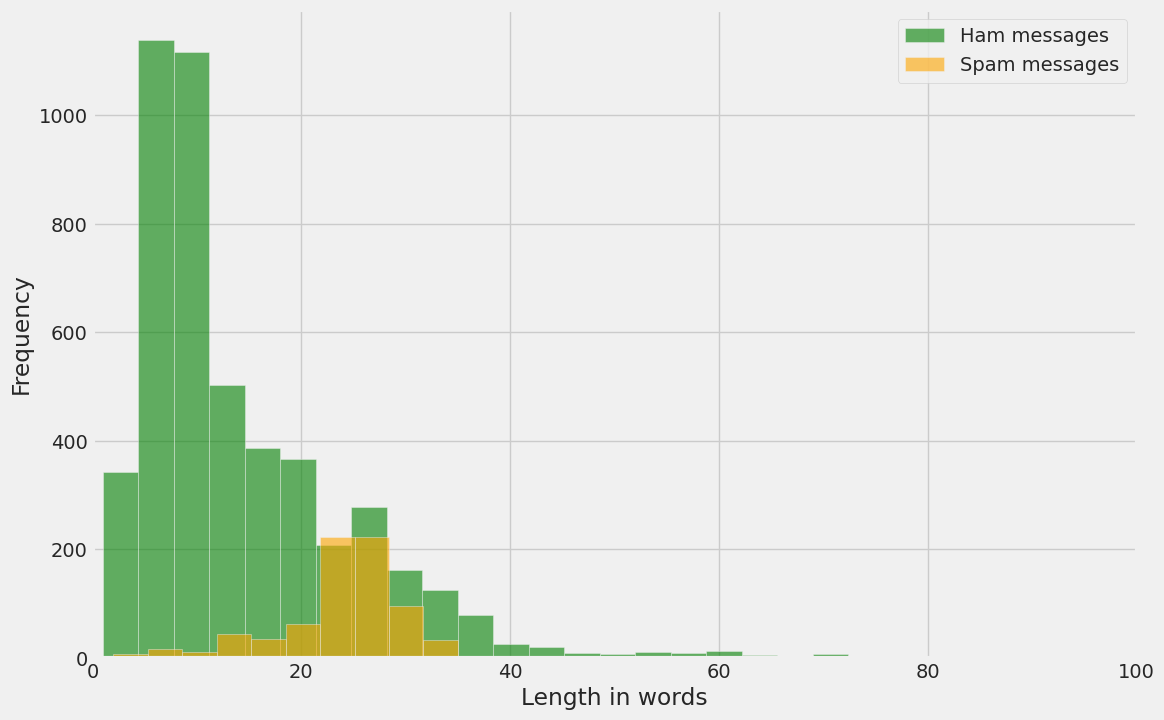

In [ ]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].word_len.plot(bins=50, kind='hist', color='green',
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].word_len.plot(kind='hist', color='orange',
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Length in words")
plt.xlim(0, 100)

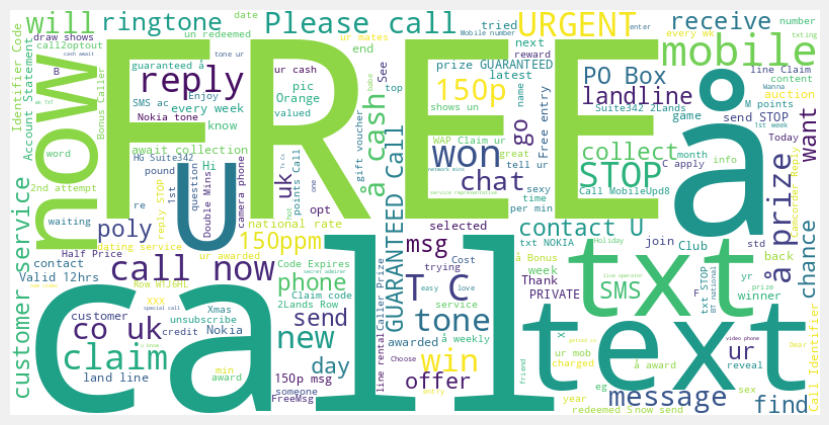

In [ ]:
spam_messages = sms[sms['label'] == 'spam']['message']
spam_text = ' '.join(spam_messages)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('')
plt.show()

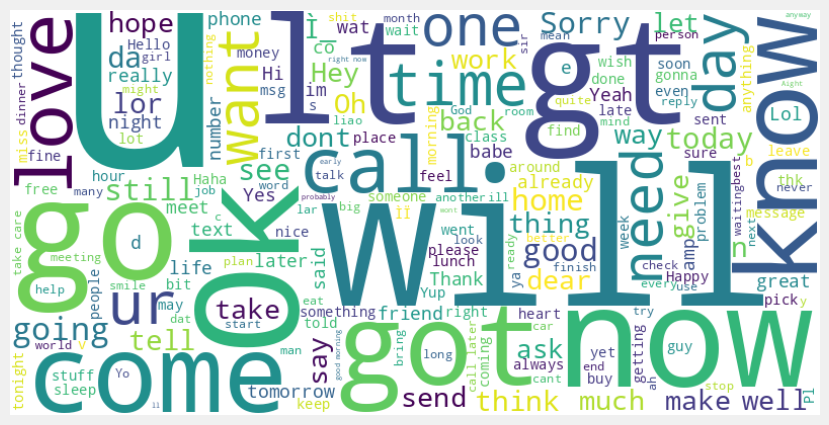

In [ ]:
ham_messages = sms[sms['label'] == 'ham']['message']
ham_text = ' '.join(ham_messages)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('')
plt.show()

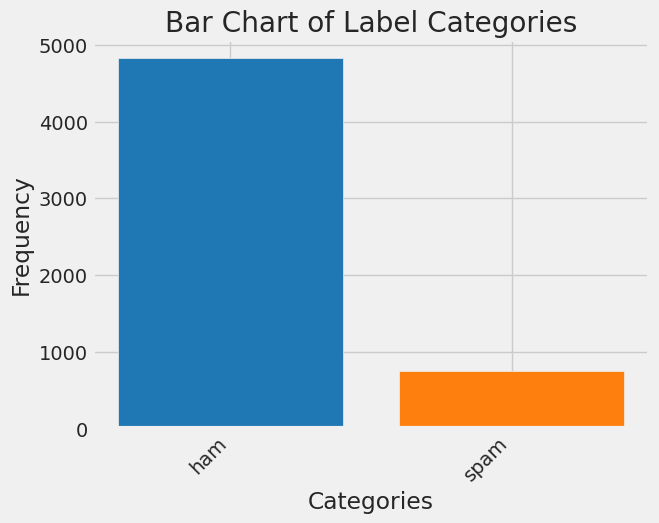

In [ ]:
label_counts = sms['label'].value_counts()

# Generate a list of distinct colors based on the number of categories
colors = plt.cm.tab10(np.arange(len(label_counts)))

# Plot the bar chart with different colors for each category
plt.bar(label_counts.index, label_counts.values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Bar Chart of Label Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

Pre-processing

In [ ]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) #Removes square brackets and their contents.
    text = re.sub('https?://\S+|www\.\S+', '', text) # Removes URLs
    text = re.sub('<.*?>+', '', text) #Removes HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Removes punctuation
    text = re.sub('\n', '', text) #Removes newline characters
    text = re.sub('\w*\d\w*', '', text) #Removes words containing digits
    return text

In [ ]:
sms['message_clean'] = sms['message'].apply(clean_text)
sms.head()

,label,message,char_len,word_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,49,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah i dont think he goes to usf he lives aroun...


###Stopwords

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', 'ur', 'dont', 'doin', 'ure' ]
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

sms['message_clean'] = sms['message_clean'].apply(remove_stopwords)
sms.head()

,label,message,char_len,word_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,49,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think goes usf lives around though


Stemming

In [ ]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [ ]:
sms['message_clean'] = sms['message_clean'].apply(stemm_text)
sms.head()

,label,message,char_len,word_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,49,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think goe usf live around though


Target Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(sms['label'])

sms['target_encoded'] = le.transform(sms['label'])
sms.head()

,label,message,char_len,word_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,29,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,49,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think goe usf live around though,0


Word Embeddings

In [ ]:
x = sms['message_clean']
y = sms['target_encoded']

In [ ]:
# Split into train(75%) and test sets(25%)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=2, max_df = 0.5)
vect.fit(x_train)

CountVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2), stop_words='english')

In [ ]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5394 sparse matrix of type '<class 'numpy.float64'>'
	with 33615 stored elements in Compressed Sparse Row format>

GLOVE

 Tokenization



In [ ]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6765

Pad_sequences

In [ ]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [ ]:
longest_train = max(x, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(x),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[   2, 3195,  274, ...,    0,    0,    0],
       [   6,  237,  530, ...,    0,    0,    0],
       [   7,  359,  589, ...,    0,    0,    0],
       ...,
       [6763, 1003, 6764, ...,    0,    0,    0],
       [ 137, 1253, 1608, ...,    0,    0,    0],
       [1994,  380,  169, ...,    0,    0,    0]], dtype=int32)

In [ ]:
'''
with gzip.open('/content/gdrive/MyDrive/Text Mining/glove.6B.100d.txt.gz', 'rt', encoding='utf-8') as gz_file:
    # Read the content of the compressed file
    content = gz_file.read()

# Write the content to a new plain text file
with open('/content/gdrive/MyDrive/Text Mining/glove.6B.100d.txt', 'w', encoding='utf-8') as txt_file:
    txt_file.write(content)

print(f"File '{output_file}' has been created.")'''

'\nwith gzip.open(\'/content/gdrive/MyDrive/Text Mining/glove.6B.100d.txt.gz\', \'rt\', encoding=\'utf-8\') as gz_file:\n    # Read the content of the compressed file\n    content = gz_file.read()\n\n# Write the content to a new plain text file\nwith open(\'/content/gdrive/MyDrive/Text Mining/glove.6B.100d.txt\', \'w\', encoding=\'utf-8\') as txt_file:\n    txt_file.write(content)\n\nprint(f"File \'{output_file}\' has been created.")'

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/gdrive/MyDrive/Text Mining/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [ ]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [ ]:
from sklearn import metrics

y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.9770279971284996
=======Confision Matrix===========


array([[1194,    8],
       [  24,  167]])

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="liblinear").fit(x_train_dtm, y_train)

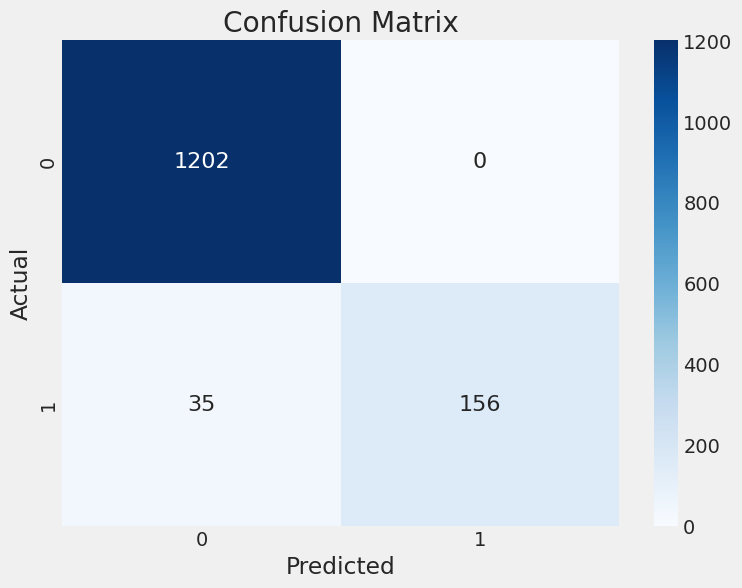

In [ ]:
from sklearn.metrics import confusion_matrix


y_pred = lr.predict(x_test_dtm)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate precision, recall, and accuracy
precision = precision_score(y_test, y_pred, pos_label=1)  # Assuming 1 is the positive class
recall = recall_score(y_test, y_pred, pos_label=1)  # Assuming 1 is the positive class
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 1.0000
Recall: 0.8168
Accuracy: 0.9749
